<a href="https://colab.research.google.com/github/Akiyoshi-Yagi/GANs/blob/master/conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import 文

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Concatenate, Dense, Embedding, Flatten, Input, Multiply, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
#諸々の入力次元の設定
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100
num_classes = 10

In [5]:
#CGANの生成器

def build_generator(z_dim):

  model = Sequential()

  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"))
  model.add(Activation("tanh"))

  return model

def build_cgan_generator(z_dim):

  z = Input(shape=(z_dim, ))
  label = Input(shape=(1, ), dtype="int32")

  #Embedding層を用いて、ラベルの埋め込みを行う
  #ラベルをz_dim次元の密ベクトルに変換する
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
  label_embedding = Flatten()(label_embedding)

  #ベクトルzと、ラベルが埋め込まれたベクトルの、要素ごとの掛け算を行う
  joined_embedding = Multiply()([z, label_embedding])

  generator = build_generator(z_dim)
  conditioned_img = generator(joined_embedding)

  return Model([z, label], conditioned_img)

In [6]:
#CGANの識別器

def build_discriminator(img_shape):

  model = Sequential()

  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1), padding="same"))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))

  return model

def build_cgan_discriminator(img_shape):

  img = Input(shape=img_shape)
  label = Input(shape=(1, ), dtype="int32")

  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
  label_embedding = Flatten()(label_embedding)
  label_embedding = Reshape(img_shape)(label_embedding)

  #画像と、ラベルが埋め込まれたテンソルを結合する
  concatenated = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)
  classification = discriminator(concatenated)

  return Model([img, label], classification)

In [7]:
#CGANモデルの構築とコンパイル

def build_gan(generator, discriminator):

  z = Input(shape=(z_dim, ))
  label = Input(shape=(1, ))

  img = generator([z, label])
  classification = discriminator([img, label])

  model = Model([z, label], classification)

  return model

discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

generator = build_cgan_generator(z_dim)
discriminator.trainable = False

cgan = build_gan(generator, discriminator)
cgan.compile(loss="binary_crossentropy", optimizer=Adam())

In [8]:
#訓練アルゴリズム

accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):

  (X_train, Y_train), (_, _) = mnist.load_data()
  X_train = X_train / 127.5 -1.0
  X_train = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    #識別器の訓練
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], Y_train[idx]

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #生成器の訓練
    z = np.random.normal(0, 1, (batch_size, z_dim))
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration+1) % sample_interval == 0:
      print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (iteration+1, d_loss[0], 100*d_loss[1], g_loss))
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      sample_images(iteration)


In [9]:
def sample_images(iteration, image_grid_rows=2, image_grid_columns=5):

  print("iteration : %d" % (iteration+1))

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  labels = np.arange(0, 10).reshape(-1, 1)
  gen_imgs = generator.predict([z, labels])
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("数字: %d" % labels[cnt])
        cnt += 1


11493376/11490434 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000 [D loss: 0.002819, acc: 100.00%] [G loss: 5.406990]
iteration : 1000
2000 [D loss: 0.003093, acc: 100.00%] [G loss: 4.975051]
iteration : 2000
3000 [D loss: 0.529360, acc: 68.75%] [G loss: 9.586336]
iteration : 3000
4000 [D loss: 0.245203, acc: 93.75%] [G loss: 5.292202]
iteration : 4000
5000 [D loss: 0.062271, acc: 96.88%] [G loss: 4.926950]
iteration : 5000
6000 [D loss: 0.095487, acc: 96.88%] [G loss: 5.279595]
iteration : 6000
7000 [D loss: 0.100826, acc: 95.31%] [G loss: 1.304656]
iteration : 7000
8000 [D loss: 0.112782, acc: 95.31%] [G loss: 3.266809]
iteration : 8000
9000 [D loss: 0.172022, acc: 92.19%] [G loss: 3.121755]
iteration : 9000
10000 [D loss: 0.103116, acc: 96.88%] [G loss: 2.668641]
iteration : 10000
11000 [D loss: 0.052823, acc: 98.44%] [G loss: 3.019902]
iteration : 11000
12000 [D loss: 0.016826, acc: 100.00%] [G loss: 1.756309]
iteration : 12000


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23383 missing from current font.
  font.set_text(s, 0, flags=flags)


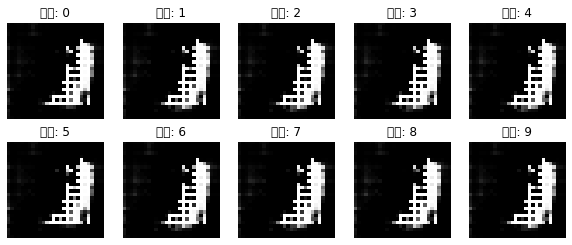

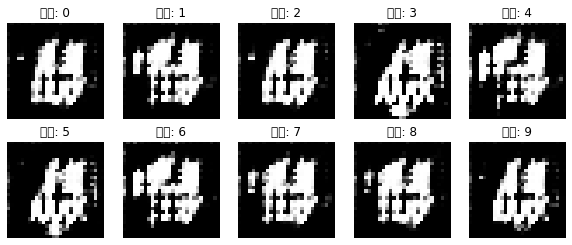

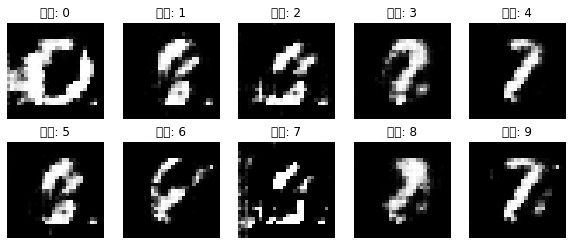

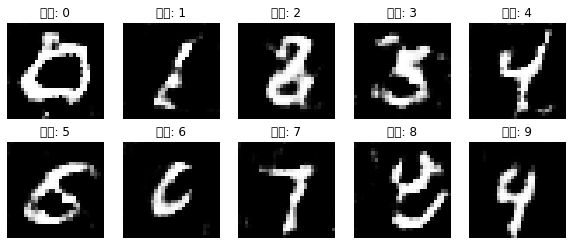

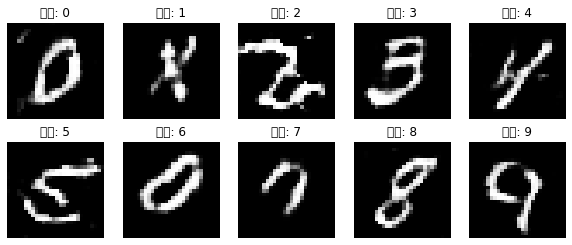

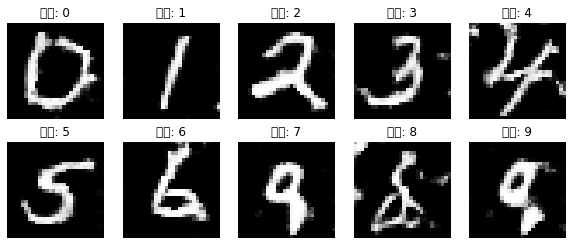

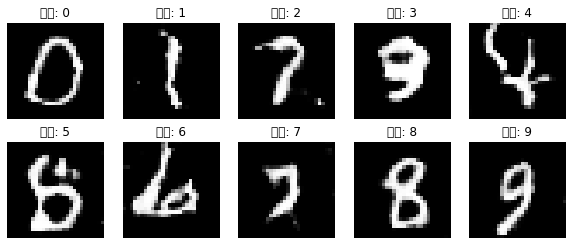

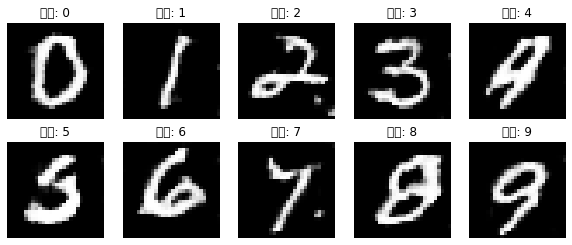

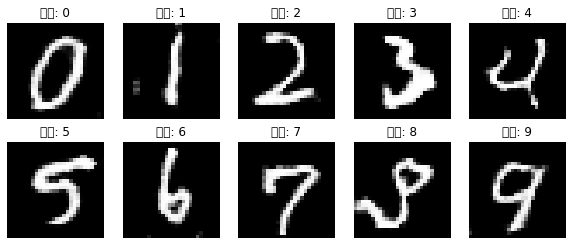

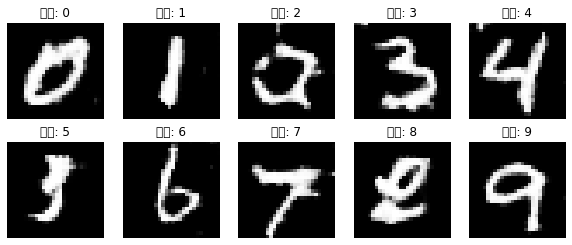

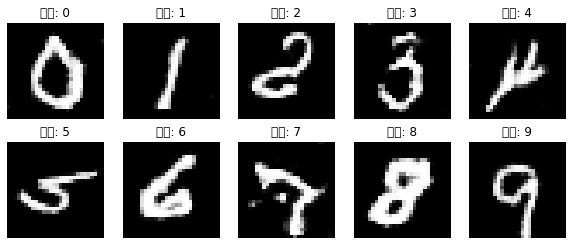

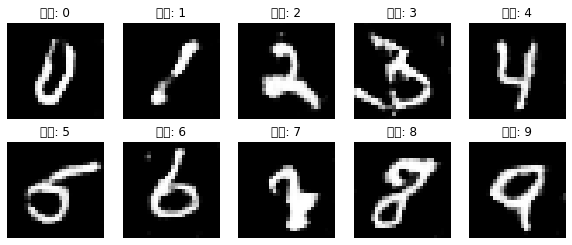

In [10]:
iterations = 12000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)